# LSTM RNN Regression

### This notebook uses RNN LSTM to predict the future close prices of currency using past values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from statistical_metrics import *
from technical_indicators import *
from sklearn import preprocessing
from collections import deque
from matplotlib.pyplot import cm
import mpld3
mpld3.enable_notebook()

Using TensorFlow backend.


In [2]:
pd.set_option("display.max_rows", 50)

In [3]:
def regression_target(df, n):
    df['Target'] = df['Price'].shift(-n)
    df.dropna(inplace=True)
    
    return df

def SMA_regression_target(df, n):
    df['Target'] = df['Price'].rolling(window=n, min_periods=n).mean()
    df['Target'] = df['Target'].round(5)
    df['Target'] = df['Target'].shift(-n)
    df.dropna(inplace=True)

    return df

df = pd.read_csv('Data/EUR_USD_1418.csv', index_col=0)

# Set how many days look ahead
look_ahead = 1
df = regression_target(df, look_ahead)
df.dropna(inplace=True)

df.drop(columns=['Change'], inplace=True)

df = moving_average(df, 5)
df = moving_average(df, 8)
df = moving_average(df, 10)
df = moving_average(df, 13)
df = moving_average(df, 15)
df = moving_average(df, 20)
df = moving_average(df, 21)
df = EMA(df, 5)
df = EMA(df, 10)
df = EMA(df, 15)
df = EMA(df, 20)
df = MACD(df, 12, 26, 9)
df = MACD(df, 21, 55, 13)
df = stochastic_oscillator(df, 5)
df = stochastic_oscillator(df, 8)
df = stochastic_oscillator(df, 10)
df = stochastic_oscillator(df, 13)
df = stochastic_oscillator(df, 15)
df = stochastic_oscillator(df, 20)
df = stochastic_oscillator(df, 21)
df = williams_R(df, 5)
df = williams_R(df, 7)
df = williams_R(df, 8)
df = williams_R(df, 10)
df = williams_R(df, 13)
df = williams_R(df, 14)
df = williams_R(df, 15)
df = williams_R(df, 20)
df = williams_R(df, 21)
df = relative_strength_index(df, 5)
df = relative_strength_index(df, 7)
df = relative_strength_index(df, 8)
df = relative_strength_index(df, 10)
df = relative_strength_index(df, 13)
df = relative_strength_index(df, 14)
df = relative_strength_index(df, 15)
df = relative_strength_index(df, 20)
df = relative_strength_index(df, 21)
df = momentum(df, 5)
df = momentum(df, 7)
df = momentum(df, 8)
df = momentum(df, 10)
df = momentum(df, 13)
df = momentum(df, 14)
df = momentum(df, 15)
df = momentum(df, 20)
df = momentum(df, 21)
df = change_rate(df, 1)
df = change_rate(df, 2)
df = change_rate(df, 3)
df = change_rate(df, 4)
df = change_rate(df, 5)
df = average_true_range(df, 7)
df = average_true_range(df, 14)
df = average_true_range(df, 21)
df = average_directional_index_and_DI(df, 5)
df = average_directional_index_and_DI(df, 7)
df = average_directional_index_and_DI(df, 8)
df = average_directional_index_and_DI(df, 10)
df = average_directional_index_and_DI(df, 13)
df = average_directional_index_and_DI(df, 14)
df = average_directional_index_and_DI(df, 15)
df = average_directional_index_and_DI(df, 20)
df = average_directional_index_and_DI(df, 21)
df.dropna(inplace=True)

# float_array = df.values.astype('float')
# min_max_scaler = preprocessing.MinMaxScaler()
# scaled_array = min_max_scaler.fit_transform(float_array)
# df = pd.DataFrame(scaled_array)

In [4]:
# Feature sets

def feature_set1(df):
    new_df = df[['Low', 'High', 'ema5', 'Open', '5ma', 'ema10', '8ma', '10ma', 'ema15', '13ma', '15ma', 'ema20', 
                 '20ma', '21ma', 'Target']].copy()
    
    return new_df

def feature_set2(df):
    new_df = df[['Price', 'Low', 'High', 'change_rate 5', 'MACD_12,26,9', 'ema5', 'momentum 20', 'Open', 'momentum 14', 
                 '21ma', 'Target']].copy()
        
    return new_df

def feature_set3(df):
    new_df = df[['Price', 'Low', 'ema5', 'High', 'momentum 21', 'MACD_21,55,13', 'momentum 7', 'ADX 5', 'Open', 
                 'momentum 20', 'MACD_12,26,9', 'change_rate 2', 'ADX 21', 'Target']].copy()
        
    return new_df


switch = {
    'feature_set1': feature_set1,
    'feature_set2': feature_set2,
    'feature_set3': feature_set3
}

In [5]:
def feature_selector(df, feature_set):
    
    df = switch[feature_set](df)
    df.dropna(inplace=True)
    return df

def load_data(df, seq_len, feature_set):
    
    df = feature_selector(df, feature_set)
    
    float_array = df.values.astype('float')
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_array = min_max_scaler.fit_transform(float_array)
    df = pd.DataFrame(scaled_array)
    
    number_of_features = len(df.columns)-1
    
    sequential_data = []  # this is a list that will CONTAIN the sequences
    target_list = []
    prev_days = deque(maxlen=seq_len)
    
    for i in df.values:
        prev_days.append(i[:-1])
        if len(prev_days) == seq_len:
            sequential_data.append(np.array(prev_days))
            target_list.append(i[-1])

    row = round(0.8 * len(sequential_data))
    
    target_list = [round(i, 5) for i in target_list ]
    
    X_train = np.array(sequential_data[:row])
    X_test = np.array(sequential_data[row:])
    y_train = np.array(target_list[:row])
    y_test = np.array(target_list[row:])
    
    return X_train, y_train, X_test, y_test, number_of_features

In [6]:
def build_model(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[0], layers[1]), return_sequences=True))
    # Dropout for regularization
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[0], layers[1]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model2(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(256, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(128, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[0], layers[1]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model3(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(256, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(128, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(32, input_shape=(layers[0], layers[1]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model4(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(64, input_shape=(layers[0], layers[1]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model5(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[0], layers[1]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,kernel_initializer='uniform',activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(4,kernel_initializer='uniform',activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model6(layers):
    d = 0.1
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[0], layers[1]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

#### validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.

In [7]:
def RNN(original_df, feature_list):
    window = 5

    n = len(feature_list)
    color_iterator = iter(cm.rainbow(np.linspace(0,1,n)))

    performance_name_list = ['rmse', 'nrmse', 'mae', 'mape']

    train_prediction_list = []
    test_prediction_list = []
    prediction_name_list = []
    performance_storage = []
    color_storage = []
    model_score_list = []

    for i in range(len(feature_list)):
        color = next(color_iterator)

        df = original_df.copy()

        X_train, y_train, X_test, y_test, number_of_features = load_data(df, window, feature_list[i])

    #     print("X_train", X_train.shape)
    #     print("y_train", y_train.shape)
    #     print("X_test", X_test.shape)
    #     print("y_test", y_test.shape)

        model = build_model([window, number_of_features])

        model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=50,
            validation_split=0.1,
            verbose=0)

        train_prediction = model.predict(X_train)
        test_prediction = model.predict(X_test)
        
        tmp_train_prediction_list = []
        tmp_test_prediction_list = []

        for x in range(len(train_prediction)):
            tmp_train_prediction_list.append(round(train_prediction[x][0], 6))

        for y in range(len(test_prediction)):
            tmp_test_prediction_list.append(round(test_prediction[y][0], 6))

        train_prediction = np.asarray(tmp_train_prediction_list, dtype=np.float32)
        test_prediction = np.asarray(tmp_test_prediction_list, dtype=np.float32)

    #         test_data = {'Actual': y_test, 'Predicted': prediction_list}
    #         df_test = pd.DataFrame(test_data)

        train_data = {'Train': y_train, 'Train_Predict': train_prediction}
        df_comparison_train = pd.DataFrame(train_data)

        test_data = {'Actual': y_test , 'Predicted': test_prediction}
        df_comparison_test = pd.DataFrame(test_data)

        rmse, nrmse = normalised_and_root_mean_square_error(df_comparison_test, 'Actual', 'Predicted')
        mae = mean_absolute_error(df_comparison_test, 'Actual', 'Predicted')
        mape = mean_absolute_percentage_error(df_comparison_test, 'Actual', 'Predicted')

    #         print('rmse: {}\nnrmse: {}\nmae: {}\nmape: {}\n'.format(rmse, nrmse, mae, mape))

        performance_list = [rmse, nrmse, mae, mape]

        # Score model
        score = model.evaluate(X_test, y_test, verbose=0)
        model_score_list.append(score[0])
        
        prediction_name_list.append('feature_set={}'.format(feature_list[i]))
        train_prediction_list.append(train_prediction)
        test_prediction_list.append(test_prediction)
        performance_storage.append(performance_list)
        color_storage.append(color)

    # Train comparison
    plt.figure(figsize=(12,8))
    plt.plot(y_train, color='black', label='actual')
    for i in range(len(train_prediction_list)):
        plt.plot(train_prediction_list[i], color=color_storage[i], label=prediction_name_list[i])

    plt.title('Model Performance on Train Set')
    plt.legend(loc='upper right')

    # Test comparison
    plt.figure(figsize=(12,8))
    plt.plot(y_test, color='black', label='actual')
    for i in range(len(test_prediction_list)):
        plt.plot(test_prediction_list[i], color=color_storage[i], label=prediction_name_list[i])

    plt.title('Model Performance on Test Set')
    plt.legend(loc='upper right')

    # Performance analysis
    tmp_list = [[] for _ in range(len(performance_list))]

    for i in range(len(performance_list)):
        for j in range(len(performance_storage)):
            tmp_list[i].append(performance_storage[j][i])

    name_data = {'Name': prediction_name_list}
    df_param_comparison = pd.DataFrame(name_data)
    for i in range(len(performance_name_list)):
        df_param_comparison[performance_name_list[i]] = tmp_list[i]

    print(df_param_comparison)

                       Name     rmse    nrmse      mae     mape
0  feature_set=feature_set3  0.02445  0.06701  0.02001  5.21014


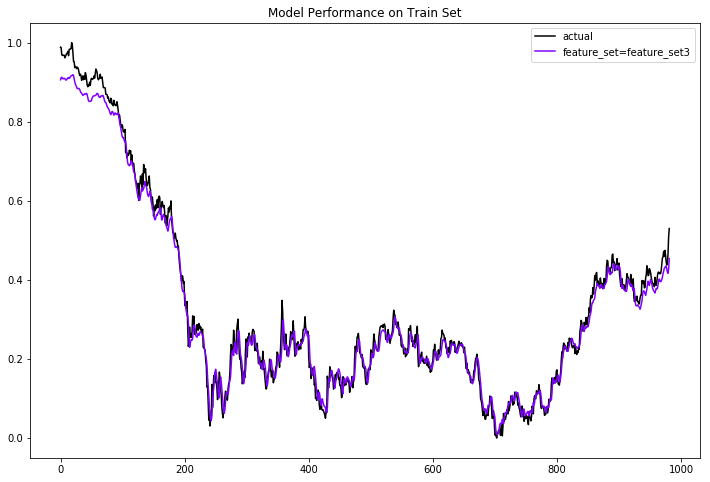

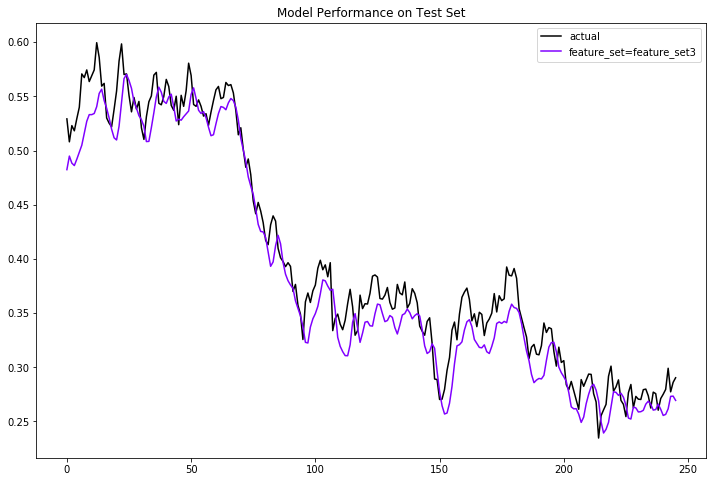

In [8]:
# feature_list = ['feature_set1']
feature_list = ['feature_set3']
RNN(df, feature_list)

In [9]:
# feature_list = ['feature_set6', 'feature_set7', 'feature_set8', 'feature_set9', 'feature_set10']
# RNN(df, feature_list)